2乗和誤差（MSE: Mean Squared Error）は下記の式から導出される
$$ E = \frac{1}{2}\displaystyle\sum_k (y_k - t_k)^2$$

In [1]:
import numpy as np
def mean_squared_error(y,t):
    return 0.5 * np.sum((y-t)**2)

In [2]:
t = [0,0,1,0,0,0,0,0,0,0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0,0.1,0.0,0.0]
mean_squared_error(np.array(y), np.array(t))

0.097500000000000031

In [3]:
y = [0.1, 0.05, 0.1,0.0,0.05,0.1,0.0,0.6,0.0,0.0]
mean_squared_error(np.array(y),np.array(t))

0.59750000000000003

一方、交差エントロピー誤差（Cross Entropy Error）は下記の式から導出される
$$ E = -\sum_k t_k\log y_k $$

In [4]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t*np.log(y+delta))

In [5]:
t = [0,0,1,0,0,0,0,0,0,0]
y = [0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0]
cross_entropy_error(np.array(y),np.array(t))

0.51082545709933802

In [6]:
y = [0.1, 0.05,0.1,0.0,0.05,0.1,0.0,0.6,0.0,0.0]
cross_entropy_error(np.array(y),np.array(t))

2.3025840929945458

In [7]:
# coding: utf-8
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.path.dirname(os.path.abspath('__file__'))
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
       _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_ont_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNISTデータセットの読み込み
    
    Parameters
    ----------
    normalize : 画像のピクセル値を0.0~1.0に正規化する
    one_hot_label : 
        one_hot_labelがTrueの場合、ラベルはone-hot配列として返す
        one-hot配列とは、たとえば[0,0,1,0,0,0,0,0,0,0]のような配列
    flatten : 画像を一次元配列に平にするかどうか 
    
    Returns
    -------
    (訓練画像, 訓練ラベル), (テスト画像, テストラベル)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_ont_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_ont_hot_label(dataset['test_label'])    
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 


if __name__ == '__main__':
    init_mnist()


Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [8]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [9]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
print("batch_mask values are: %s" % batch_mask)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]
np.random.choice(60000,10)

batch_mask values are: [45560 19626 42097 38295 31882 34181 46912 10637 26141 36674]


array([50599, 35717, 20247, 10543, 48451, 26458,  2860, 25904, 44470,  5262])

In [10]:
def cross_entropy_error(y,t):
    if y.ndim == 1:
        t = t.reshape(1,t.size)
        y = y.reshape(1,y.size)
    batch_size = y.shape[0]
    return -np.sum(t*np.log(y)) / batch_size


教師データtがone-hot表現ではなく、ラベルで与えられた時の交差エントロピー誤差を計算するメソッドは次のようになる

In [11]:
def corss_entropy_error(y, t):
    if y.din == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size)]))/batch_size

数値微分の関数を定義する。ここではhを丸め誤差を考慮し$10^{-4}$とし、なおかつ$h$の前後の差分を用いて計算する

In [16]:
def numerical_diff(f,x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

下記の式をPythonを用いて実装する
$$y = 0.01x^2 + 0.1x$$

In [17]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

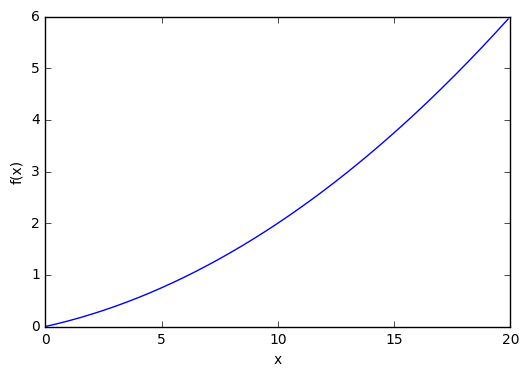

In [18]:
import numpy as np
import matplotlib.pylab as plt
x = np.arange(0.0,20.0,0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x,y)
plt.show()

In [19]:
numerical_diff(function_1, 5)

0.1999999999990898

In [20]:
numerical_diff(function_1, 10)

0.2999999999986347

一方下記のような２変数関数を考える

$$f(x_0, x_1) = x_0^2 + x_1^2$$

In [22]:
def function_2(x):
    return x[0]**2 + x[1]**2

勾配法は次式で表される
$$x_0 = x_0 - \eta \frac{\partial f}{\partial x_0}$$
$$x_1 = x_1 - \eta \frac{\partial f}{\partial x_1}$$

In [23]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f,x)
        x -= lr * grad
    return x

In [25]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

ImportError: No module named 'common.functions'